In [1]:
import matplotlib
from seismic_code.events import parallel_get_event_times
from seismic_code.waveforms import parallel_write_waveforms
from obspy.core.event import Catalog
from seismic_code.helpers import *
from seismic_code.async_client import AsyncClient
import warnings
import argparse
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from obspy.core.utcdatetime import UTCDateTime
from types import MappingProxyType


class NotEnoughEvents(Exception):
    pass

class Names:
    Amatrice = 'Amatrice'
    Oklahoma = 'Oklahoma'
    SouthAmerica = 'SouthAmerica'
    California = 'California'
    Alaska = 'Alaska'
    Costa = 'Costa'
    Puerto = 'Puerto'
    Utah = 'Utah'

def Day(num):
    return 60*60*24*num

In [2]:
!echo $PATH
os.environ

/opt/conda/bin:/opt/conda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin


environ{'HOSTNAME': '938764e21032',
        'HOME': '/root',
        'PATH': '/opt/conda/bin:/opt/conda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin',
        'LANG': 'C.UTF-8',
        'LC_ALL': 'C.UTF-8',
        'PROJ_LIB': '/opt/conda/share/proj',
        'PWD': '/data',
        'JPY_PARENT_PID': '8',
        'TERM': 'xterm-color',
        'CLICOLOR': '1',
        'PAGER': 'cat',
        'GIT_PAGER': 'cat',
        'MPLBACKEND': 'module://ipykernel.pylab.backend_inline'}

## Configuration

In [3]:
def get_event_info(name):
    """
    Provids a dictionary (MappingProxyType) of information to populate the global variables needed in the file.
    The chosen event is in a seismologically active area. A station is chosen near the event to get data.
    @param name: Can be one of - "Amatrice", "Patitirion"
    @return: ProxyMapType, containing the information about the event.
    """
    info: MappingProxyType = None
    if name == Names.Amatrice:
        info = dict(
            Latitude='42.790',
            Longitude='13.150',
            Time="2016-08-24 03:36:32",
            StartTime="2012-08-24",
            EndTime="2018-08-24",
            Client="INGV",
            Name="Amatrice",
            PrePadding=4,
            PostPadding=16,
            StationRadius=.2,
            LocalEventRadius=.2
        )

    elif name == Names.Oklahoma:
        info = dict(
            Latitude='37.081',
            Longitude='-97.309',
            Time="2018-5-15 20:14:49",
            StartTime="2015-10-15",
            EndTime="2017-10-15",
            Client="IRIS",
            Name="Oklahoma",
            PrePadding=6,
            PostPadding=14,
            Network="GS",
            Station='KAN01',
            StationRadius=1,
            LocalEventRadius=1
        )
    
    elif name == Names.SouthAmerica:
        info = dict(
            Latitude='-25.3',
            Longitude='-71',
            Time="2018-02-20 23:18:32",
            StartTime="2013-10-15",
            EndTime="2018-01-15",
            Client="IRIS",
            Name="SouthAmerica",
            PrePadding=3,
            PostPadding=17,
            AddTime=10,
            Network='C',
            Station='GO02',
            StationRadius=3,
            LocalEventRadius=1
        )
    
    elif name == Names.California:
        info = dict(
            Latitude='33.557',
            Longitude='-115.888',
            Time="2018-02-20 23:18:32",
            StartTime="2016-10-15",
            EndTime="2018-01-15",
            Client="IRIS",
            Name="California",
            Network='NN',
            Station='PIO',
            PrePadding=8,
            PostPadding=12,
            StationRadius=1,
            LocalEventRadius=1
        )
    
    elif name == Names.Alaska:
        info = dict(
            Latitude='61',
            Longitude='-150',
            Time="2018-02-20 23:18:32",
            StartTime="2015-01-01",
            EndTime="2017-02-26",
            Client="IRIS",
            Network="AK",
            Station="FIRE",
            Name="Alaska",
            PrePadding=5,
            PostPadding=15,
            StationRadius=2,
            LocalEventRadius=1.5
        )
        
    elif name == Names.Costa:
        info = dict(
            Latitude='19.433',
            Longitude='-155',
            Time="2005-02-20",
            StartTime="2014-05-05",
            EndTime="2018-02-26",
            Client="IRIS",
            Network="NU",
            Station="BC8A",
            Name="Costa",
            PrePadding=5,
            PostPadding=15,
            StationRadius=1,
            LocalEventRadius=1
        )
        
    elif name == Names.Puerto:
        info = dict(
            Latitude='18',
            Longitude='-67',
            Time="2005-02-20",
            StartTime="2014-05-05",
            EndTime="2018-02-26",
            Client="IRIS",
            Network="PR",
            Station="AGPR",
            Name="Puerto",
            PrePadding=7,
            PostPadding=13,
            StationRadius=3,
            LocalEventRadius=1
        )
        
    elif name == Names.Utah:
        info = dict(
            Latitude='38',
            Longitude='-112',
            Time="2006-04-20",
            StartTime="2015-10-05",
            EndTime="2018-02-26",
            Client="IRIS",
            Network="NN",
            Station="DSP",
            Name="Utah",
            PrePadding=5,
            PostPadding=15,
            StationRadius=5,
            LocalEventRadius=1.5
        )
    
    if info: 
        return MappingProxyType(info)
    raise ValueError(f"Name '{name}' not found")


## Define Constants

In [4]:
event_name = Names.Puerto    # Get name based on configuration
event = get_event_info(event_name)   # dict containing the information to populate the variables

NETWORK = event['Network']
STATION = event['Station']

NUM_EVENTS = 20             # 5000
NUM_NOISE_EVENTS = 20       # 5000
MAX_RADIUS = 3              # Radius to capture events in
DURATION = 20               # Length of file in seconds to get
PRE_PADDING = 6             # Length before event time to start
POST_PADDING = 14           # Length after event time to end

# Code
client = AsyncClient(CLIENT_NAME)
inventory = client.get_stations(network=NETWORK,
                                station=STATION)
network = inventory.select(NETWORK)[0]
station = network.select(STATION)[0]



WAVEFORMS_PATH = os.path.join(os.getcwd(), f"waveforms/example")


STARTTIME = UTCDateTime(event['StartTime']) # Starttime of Data Collection
ENDTIME = UTCDateTime(event['EndTime'])     # Endtime of Data Collection
NOISE_START = STARTTIME
NOISE_END = STARTTIME + Day(60)

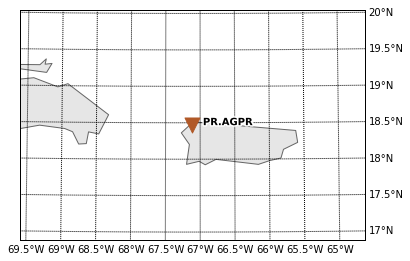

In [6]:
# Visualize the Station
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    network.select(STATION).plot(projection='local')
    

## Get Events

In [5]:
# Local Events
local_catalog = client.get_events(latitude=station.latitude,
                                  longitude=station.longitude,
                                  maxradius=MAX_RADIUS,  # Local
                                  starttime=STARTTIME,
                                  limit=NUM_EVENTS,
                                  endtime=ENDTIME
                                  )

# Noise Exclude Events
noise_catalog = client.get_events(latitude=station.latitude,
                                  longitude=station.longitude,
                                  starttime=NOISE_START,
                                  endtime=NOISE_END,
                                  maxradius=10
                                 )

print("LOCAL EVENTS:", len(local_catalog))
print("NOISE EVENTS to Exclude:", len(noise_catalog))

LOCAL EVENTS: 20
NOISE EVENTS to Exclude: 1144


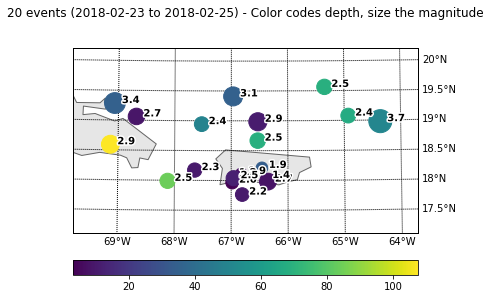

In [6]:
# Plot Events
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    local_catalog.plot(projection="local")

In [7]:
# Correct Events Times and retrieve times from catalog
local_times = parallel_get_event_times(local_catalog, station)
exclude_noise_times = parallel_get_event_times(noise_catalog, station,
                                        give_anyways=True)                  # Even if PREM arrival can't be computed, get event times uncorrected

noise_times = get_noise_times(exclude_noise_times,
                              NOISE_START,  # startafter
                              NOISE_END,  # endbefore
                              NUM_NOISE_EVENTS,
                              DURATION)
print("Got times")


Got times


## Retrieve from Global Database on IRIS server

In [8]:
# Functions
end = lambda time: time + PADDING
start = lambda time: time - PADDING

def create_bulk(times):
    return [(network.code, station.code, "*", "HN*", start(time), end(time)) for time in times]

local_bulk = create_bulk(local_times)
noise_bulk = create_bulk(noise_times)
print("Created Bulks")


Created Bulks


In [9]:
# Get Waveforms
local_waveforms = client.get_waveforms_bulk(local_bulk,
                                            batch_size=5,
                                            bulk_kwargs=dict(attach_response=True),
                                            skip_errors=True)
print("\nRetrieved Local:", len(local_waveforms))

Got batch 4: 20/20
Done.

Retrieved Local: 20


In [10]:
noise_waveforms = client.get_waveforms_bulk(noise_bulk,
                                            batch_size=5,
                                            bulk_kwargs=dict(attach_response=True),
                                            skip_errors=True)
print("\nRetrieved Noise:", len(noise_waveforms))

Got batch 4: 20/20
Done.

Retrieved Noise: 20


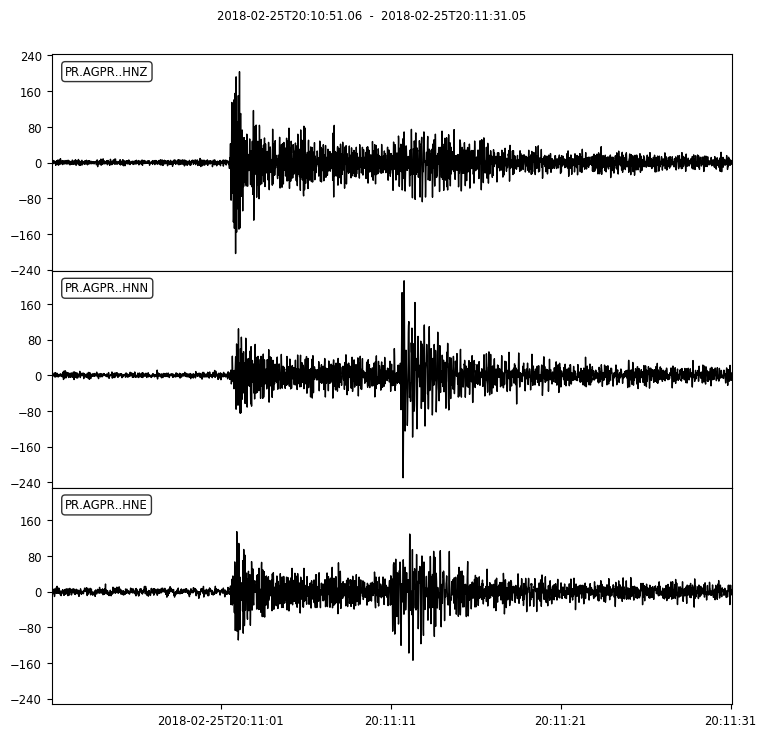

In [11]:
# Show waveforms, as an example
local_waveform = local_waveforms[2]
local_waveform.filter('bandpass', freqmin=1, freqmax=30).plot()

In [23]:
# Write Waveforms
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    parallel_write_waveforms(local_waveforms, os.path.join(WAVEFORMS_PATH, "local"))
    parallel_write_waveforms(noise_waveforms, os.path.join(WAVEFORMS_PATH, "noise"))

print("Finished Writing")

Writing Waveforms...

Wrote Waveforms
Writing Waveforms...

Wrote Waveforms
Finished Writing
